# Gesture Recognition Case Study

## <font color="blue"> Introduction:

This case study aims at the automatic interpretation of gestures in order to offer new possibilities to interact with machine and to design more natural and more intuitive interactions with computing machines.

## <font color="blue"> Problem Statement:
- The company called Home Electronics which manufactures state of art televisions and the company wants to develop a cool feature in the smart-TV that can recognise five gestures performed by the user which will help users control the TV without using the remote.

- The gestures are continuously monitered by the webcam mounted on the TV. Each gesture corresponds to a specific command:
  1. **Thumbs up**     : Increase the volume 
  2. **Thumbs down**   : Decrease the volumn
  3. **Left swipe**    : Jump backwards 10 seconds
  4. **Right swipe**   : Jump forward 10 seconds
  5. **Stop**          : Pause the movie

## <font color="blue"> Objectives:

- We are required to build a gesture recognition model using neural network which should have generators that are able to take batches of data without error and with optimized number of parameters so that the inference or prediction time should be less.
- The architecture we are going to use is:
 1. 3D Convs
 2. CNN + RNN stacked

## <font color="blue">Importing Libraries:

In [1]:
#pip install scipy==1.1.0

In [2]:
## Importing all necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.misc import imread, imresize
from skimage import io
import datetime
import random as rn
from keras import backend as K
from keras import layers
import tensorflow as tf

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, Conv2D, MaxPooling2D, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import mobilenet
from keras import optimizers

# Ignoring warnings
import warnings
warnings.filterwarnings("ignore")

## <font color="blue"> Data Preprocessing:

**Setting the seed value**:

In [3]:
# Setting a seed value for consistency
np.random.seed(30)
rn.seed(30)
tf.random.set_seed(30)

**Reading folder names for training and validation and setting up the batch size**

In [4]:
# Reading the folder names for train and val
train_doc = np.random.permutation(open("datasets/Project_data/train.csv").readlines())
val_doc = np.random.permutation(open("datasets/Project_data/val.csv").readlines())

# Setting the batch size
batch_size = 42

**Creating the generator**

In [5]:
# Creating the generator function
def generator(source_path, folder_list, batch_size, frames, img_height, img_width):
  print("source path = ", source_path, "; batch size = ",batch_size)

  # Selecting middle 20 image instances in the overall 30 instances
  img_idx = list(np.round(np.linspace(0,29,frames)).astype(int))

  while True:
    t = np.random.permutation(folder_list)
    num_batches = len(t) // batch_size

    for batch in range(num_batches):
      batch_data = np.zeros((batch_size,len(img_idx),img_height,img_width,3))
      batch_labels = np.zeros((batch_size,5))
      for folder in range(batch_size):
        imgs = os.listdir(source_path+"/"+t[folder+ (batch*batch_size)].split(";")[0])
        for idx,item in enumerate(img_idx):
          image = imread(source_path+"/"+t[folder + (batch*batch_size)].strip().split(";")[0]+"/"+imgs[item]).astype(np.float32)
         
          # Resizing the image to 180*180*3 size 
          image = imresize(image, (180,180,3))
          # Cropping the image to final shape of 140*140*3 size
          start_height = int((180-int(img_height))/2)
          start_width = int((180-int(img_width))/2)
          image = image[start_height:start_height+int(img_height),start_width:start_width+int(img_width),:]

          # Normalizing the data
          batch_data[folder,idx,:,:,0] = image[:,:,0]/255.
          batch_data[folder,idx,:,:,1] = image[:,:,1]/255.
          batch_data[folder,idx,:,:,2] = image[:,:,2]/255.

        batch_labels[folder, int(t[folder+ (batch*batch_size)].strip().split(";")[2])] = 1
      yield batch_data, batch_labels

    # Writing code for the remaining data points left
    remaining_seq = len(t) % batch_size

    rem_batch_data = np.zeros((remaining_seq,len(img_idx),img_height,img_width,3))
    rem_batch_labels = np.zeros((remaining_seq,5))
    for folder_left in range(remaining_seq):
      imgs = os.listdir(source_path+"/"+t[folder_left + (num_batches*batch_size)].split(";")[0])
      for idx,item in enumerate(img_idx):
        image = imread(source_path+"/"+t[folder_left + (num_batches*batch_size)].strip().split(";")[0]+"/"+imgs[item]).astype(np.float32)
       
        # Resizing the image to 180*180*3 size
        image = imresize(image, (180,180,3))
        # Cropping the image to final shape of 140*140*3 size
        image = image[start_height:start_height+int(img_height),start_width:start_width+int(img_width),:]

        # Normalizing the data
        rem_batch_data[folder_left,idx,:,:,0] = image[:,:,0]/255.
        rem_batch_data[folder_left,idx,:,:,1] = image[:,:,1]/255.
        rem_batch_data[folder_left,idx,:,:,2] = image[:,:,2]/255.

      rem_batch_labels[folder_left, int(t[folder_left + (num_batches*batch_size)].strip().split(";")[2])] = 1
    yield rem_batch_data, rem_batch_labels 

**Reading the source path and defining number of epochs and checking the number of training and validation sequences**

In [6]:
# Creating current date time for checkpoint purpose
curr_dt_time = datetime.datetime.now()

# Reading the path of the train and val data
train_path = "datasets/Project_data/train"
val_path = "datasets/Project_data/val"

# Checking the number of training and validation data
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# Defining number of epochs
num_epochs = 30
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


## <font color="blue"> Model Building:

### **3D Convs Architecture**:

**Buiding the model**

In [7]:
# Building 3d Convs network
num_classes = 5
frames = 20
img_height=120
img_width = 120

# Adding layers to the network
model = Sequential([
                    layers.Conv3D(32, (3,3,3), input_shape=(frames,img_height,img_width,3),padding="same"),
                    layers.Activation("relu"),
                    layers.MaxPooling3D(pool_size=(2,2,2)),
                    layers.Conv3D(32, (3,3,3), padding="same"),
                    layers.Activation("relu"),
                    layers.MaxPooling3D(pool_size=(2,2,2)),
                    layers.Conv3D(64, (3,3,3), padding="same"),
                    layers.Activation("relu"),
                    layers.MaxPooling3D(pool_size=(2,2,2)),
                    layers.Dropout(0.25),

                    layers.Flatten(),
                    layers.Dense(64, activation="relu"),
                    layers.Dense(num_classes, activation="softmax")
])

2022-06-15 14:54:45.098933: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-06-15 14:54:45.098990: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14803 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3f:00.0, compute capability: 7.5


**Compiling and checking the summary of the model**

In [8]:
# Choosing the optimizer
optimiser = "Adam"

# Compiling the model
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Printing the summary
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 120, 120, 32)  2624      
                                                                 
 activation (Activation)     (None, 20, 120, 120, 32)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 60, 60, 32)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 60, 60, 32)    27680     
                                                                 
 activation_1 (Activation)   (None, 10, 60, 60, 32)    0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 5, 30, 30, 32)    0         
 3D)                                                    

**Creating train and val generator**

In [9]:
# Creating train and validation generator
batch_size=42
frames = 20
img_height = 140
img_width = 140
train_generator = generator(train_path, train_doc, batch_size,frames, img_height, img_width)
val_generator = generator(val_path, val_doc, batch_size, frames, img_height, img_width)

**Creating Callbacks**

In [10]:
# Creating model name
curr_dt_time = datetime.datetime.now()
model_name = "model_init" + "_" + str(curr_dt_time).replace(" ","").replace(":","_") + '/'

if not os.path.exists(model_name):
  os.mkdir(model_name)

filepath = model_name + "model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5"

# Creating checkpoint
checkpoint = ModelCheckpoint(filepath, moniter="val_loss", verbose=1, save_best_only=False, save_weights_only=False, mode="auto",period=1)

# Defining the learning rate
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
callbacks_list = [checkpoint, LR]

**Assigning steps per epoch**

In [11]:
# For training data
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

# for validation data
if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

**Fitting the model**

In [31]:
# fitting the model
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

source path =  datasets/Project_data/train ; batch size =  42
Epoch 1/20


2022-06-15 11:21:27.434986: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


16/16 [==============================] - ETA: 0s - loss: 1.7472 - categorical_accuracy: 0.1961source path =  datasets/Project_data/val ; batch size =  42

Epoch 00001: saving model to model_init_2022-06-1511_21_17.673150/model-00001-1.74716-0.19608-1.57711-0.20000.h5
16/16 [==============================] - 85s 5s/step - loss: 1.7472 - categorical_accuracy: 0.1961 - val_loss: 1.5771 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/20
16/16 [==============================] - ETA: 0s - loss: 1.5364 - categorical_accuracy: 0.3107
Epoch 00002: saving model to model_init_2022-06-1511_21_17.673150/model-00002-1.53644-0.31071-1.34837-0.37000.h5
16/16 [==============================] - 72s 5s/step - loss: 1.5364 - categorical_accuracy: 0.3107 - val_loss: 1.3484 - val_categorical_accuracy: 0.3700 - lr: 0.0010
Epoch 3/20
16/16 [==============================] - ETA: 0s - loss: 1.1648 - categorical_accuracy: 0.5339
Epoch 00003: saving model to model_init_2022-06-1511_21_17.673150/model-000

In [12]:
# Creating a function for plotting training and validation loss
def plot(model_name):
    fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(model_name.history["loss"])
    axes[0].plot(model_name.history["val_loss"])
    axes[0].legend(["loss","val_loss"])
    
    axes[1].plot(model_name.history["categorical_accuracy"])
    axes[1].plot(model_name.history["val_categorical_accuracy"])
    axes[1].legend(["categorical_accuracy", "val_categorical_accuracy"])

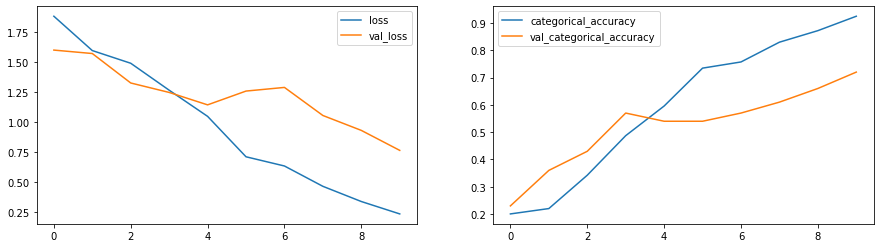

In [15]:
# Plotting the model history
plot(model.history)

In [26]:
# Adding batch normalization layers
model_2 = Sequential([
                    layers.Conv3D(32, (3,3,3), input_shape=(frames,img_height,img_width,3),padding="same", activation="relu"),             
                    layers.MaxPooling3D(pool_size=(2,2,2)),
                    
                    layers.Conv3D(32, (3,3,3), padding="same", activation="relu"),
                    layers.MaxPooling3D(pool_size=(2,2,2)),
                    
                    layers.Conv3D(64, (3,3,3), padding="same", activation="relu"),
                    layers.MaxPooling3D(pool_size=(2,2,2)),
                    layers.Dropout(0.5),

                    layers.Flatten(),
                    layers.Dense(64, activation="relu"),
                    layers.BatchNormalization(),
                    layers.Dense(num_classes, activation="softmax")
])

In [27]:
# Checking the summary
model_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_9 (Conv3D)           (None, 20, 140, 140, 32)  2624      
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 10, 70, 70, 32)   0         
 3D)                                                             
                                                                 
 conv3d_10 (Conv3D)          (None, 10, 70, 70, 32)    27680     
                                                                 
 max_pooling3d_10 (MaxPoolin  (None, 5, 35, 35, 32)    0         
 g3D)                                                            
                                                                 
 conv3d_11 (Conv3D)          (None, 5, 35, 35, 64)     55360     
                                                                 
 max_pooling3d_11 (MaxPoolin  (None, 2, 17, 17, 64)   

In [28]:
# Compiling the model
model_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [29]:
# fitting the model
model_2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10
16/16 [==============================] - ETA: 0s - loss: 1.4083 - categorical_accuracy: 0.4404
Epoch 00001: saving model to model_init_2022-06-1507_38_33.814701/model-00001-1.40834-0.44042-3.58308-0.29000.h5
16/16 [==============================] - 62s 4s/step - loss: 1.4083 - categorical_accuracy: 0.4404 - val_loss: 3.5831 - val_categorical_accuracy: 0.2900 - lr: 0.0010
Epoch 2/10
16/16 [==============================] - ETA: 0s - loss: 0.9085 - categorical_accuracy: 0.6667
Epoch 00002: saving model to model_init_2022-06-1507_38_33.814701/model-00002-0.90854-0.66667-3.38186-0.31000.h5
16/16 [==============================] - 62s 4s/step - loss: 0.9085 - categorical_accuracy: 0.6667 - val_loss: 3.3819 - val_categorical_accuracy: 0.3100 - lr: 0.0010
Epoch 3/10
16/16 [==============================] - ETA: 0s - loss: 0.6561 - categorical_accuracy: 0.7858
Epoch 00003: saving model to model_init_2022-06-1507_38_33.814701/model-00003-0.65609-0.78582-1.51093-0.44000.h5
16/16 [====

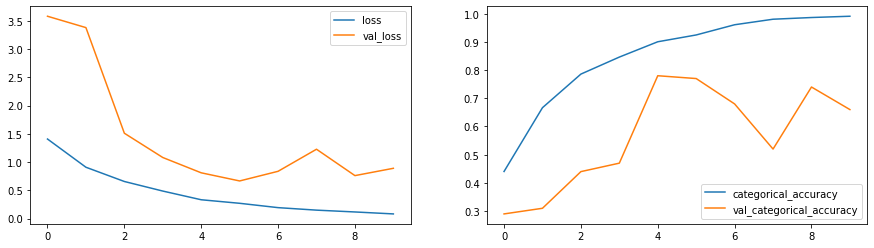

In [30]:
# Plotting the model history
plot(model_2.history)

In [32]:
# Building third model with less learning rate
model_3 = Sequential([
                    layers.Conv3D(32, (3,3,3), input_shape=(frames,img_height,img_width,3),padding="same", activation="relu"),             
                    layers.MaxPooling3D(pool_size=(2,2,2)),
                    
                    layers.Conv3D(32, (3,3,3), padding="same", activation="relu"),
                    layers.MaxPooling3D(pool_size=(2,2,2)),
                    
                    layers.Conv3D(64, (3,3,3), padding="same", activation="relu"),
                    layers.MaxPooling3D(pool_size=(2,2,2)),
                    layers.Dropout(0.5),

                    layers.Flatten(),
                    layers.Dense(64, activation="relu"),
                    layers.BatchNormalization(),
                    layers.Dense(num_classes, activation="softmax")
])

In [47]:
# Compiling the model
K.set_value(model_3.optimizer.learning_rate, 0.0005) 
model_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [49]:
# fitting the model
model_3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10
16/16 [==============================] - ETA: 0s - loss: 1.4528 - categorical_accuracy: 0.4133
Epoch 00001: saving model to model_init_2022-06-1508_12_06.373935/model-00001-1.45278-0.41327-1.68866-0.21000.h5
16/16 [==============================] - 66s 4s/step - loss: 1.4528 - categorical_accuracy: 0.4133 - val_loss: 1.6887 - val_categorical_accuracy: 0.2100 - lr: 5.0000e-04
Epoch 2/10
16/16 [==============================] - ETA: 0s - loss: 0.9706 - categorical_accuracy: 0.6410
Epoch 00002: saving model to model_init_2022-06-1508_12_06.373935/model-00002-0.97060-0.64103-1.54929-0.27000.h5
16/16 [==============================] - 62s 4s/step - loss: 0.9706 - categorical_accuracy: 0.6410 - val_loss: 1.5493 - val_categorical_accuracy: 0.2700 - lr: 5.0000e-04
Epoch 3/10
16/16 [==============================] - ETA: 0s - loss: 0.6853 - categorical_accuracy: 0.7783
Epoch 00003: saving model to model_init_2022-06-1508_12_06.373935/model-00003-0.68531-0.77828-1.34887-0.42000.h5
16/

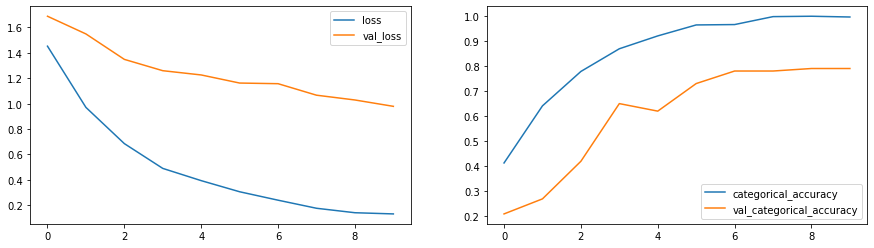

In [58]:
plot(model_3.history)

In [84]:
# Building fourth model with all 30 instances
batch_size=42
frames = 30
img_height = 140
img_width = 140
train_generator = generator(train_path, train_doc, batch_size,frames, img_height, img_width)
val_generator = generator(val_path, val_doc, batch_size, frames, img_height, img_width)
model_4 = Sequential([
                    layers.Conv3D(32, (3,3,3), input_shape=(frames,img_height,img_width,3),padding="same", activation="relu"),             
                    layers.MaxPooling3D(pool_size=(2,2,2)),
                    
                    layers.Conv3D(32, (3,3,3), padding="same", activation="relu"),
                    layers.MaxPooling3D(pool_size=(2,2,2)),
                    
                    layers.Conv3D(64, (3,3,3), padding="same", activation="relu"),
                    layers.MaxPooling3D(pool_size=(2,2,2)),
                    layers.Dropout(0.5),

                    layers.Flatten(),
                    layers.Dense(64, activation="relu"),
                    layers.BatchNormalization(),
                    layers.Dense(num_classes, activation="softmax")
])

In [55]:
# Compiling the model
K.set_value(model_4.optimizer.learning_rate, 0.0005) 
model_4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [56]:
# Fitting the model
model_4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10
16/16 [==============================] - ETA: 0s - loss: 1.3750 - categorical_accuracy: 0.4329
Epoch 00001: saving model to model_init_2022-06-1508_36_59.454944/model-00001-1.37497-0.43288-5.60121-0.28000.h5
16/16 [==============================] - 66s 4s/step - loss: 1.3750 - categorical_accuracy: 0.4329 - val_loss: 5.6012 - val_categorical_accuracy: 0.2800 - lr: 5.0000e-04
Epoch 2/10
16/16 [==============================] - ETA: 0s - loss: 0.8572 - categorical_accuracy: 0.6863
Epoch 00002: saving model to model_init_2022-06-1508_36_59.454944/model-00002-0.85717-0.68627-3.35512-0.36000.h5
16/16 [==============================] - 64s 4s/step - loss: 0.8572 - categorical_accuracy: 0.6863 - val_loss: 3.3551 - val_categorical_accuracy: 0.3600 - lr: 5.0000e-04
Epoch 3/10
16/16 [==============================] - ETA: 0s - loss: 0.6092 - categorical_accuracy: 0.7903
Epoch 00003: saving model to model_init_2022-06-1508_36_59.454944/model-00003-0.60916-0.79035-2.01667-0.35000.h5
16/

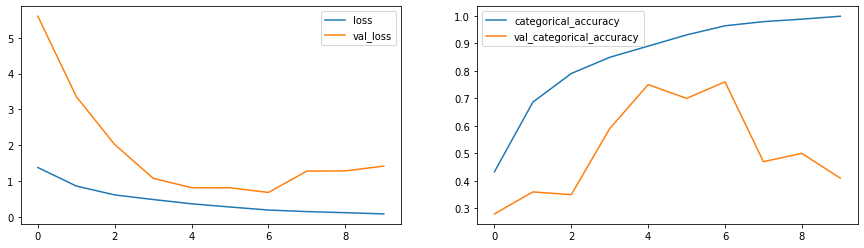

In [59]:
plot(model_4.history)

In [61]:
# Building fifth model with all 30 instances
batch_size=42
frames = 20
img_height = 140
img_width = 140
train_generator = generator(train_path, train_doc, batch_size,frames, img_height, img_width)
val_generator = generator(val_path, val_doc, batch_size, frames, img_height, img_width)
model_5 = Sequential([
                    layers.Conv3D(32, (3,3,3), input_shape= (frames,img_height,img_width,3),padding="same", activation="relu"),             
                    layers.MaxPooling3D(pool_size=(2,2,2)),
                    layers.Dropout(0.25),
                    
                    layers.Conv3D(32, (3,3,3), padding="same", activation="relu"),
                    layers.MaxPooling3D(pool_size=(2,2,2)),
                    layers.Dropout(0.25),
                    
                    layers.Conv3D(64, (3,3,3), padding="same", activation="relu"),
                    layers.MaxPooling3D(pool_size=(2,2,2)),
                    layers.Dropout(0.5),

                    layers.Flatten(),
                    layers.Dense(64, activation="relu"),
                    layers.BatchNormalization(),
                    layers.Dense(num_classes, activation="softmax")
])

In [62]:
# Compiling the model
model_5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
K.set_value(model_5.optimizer.learning_rate, 0.0005)

In [64]:
# Fitting the model
model_5.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10
16/16 [==============================] - ETA: 0s - loss: 1.4107 - categorical_accuracy: 0.4449
Epoch 00001: saving model to model_init_2022-06-1508_56_27.660802/model-00001-1.41072-0.44495-5.65080-0.27000.h5
16/16 [==============================] - 67s 4s/step - loss: 1.4107 - categorical_accuracy: 0.4449 - val_loss: 5.6508 - val_categorical_accuracy: 0.2700 - lr: 5.0000e-04
Epoch 2/10
16/16 [==============================] - ETA: 0s - loss: 1.1094 - categorical_accuracy: 0.5505
Epoch 00002: saving model to model_init_2022-06-1508_56_27.660802/model-00002-1.10943-0.55053-7.39292-0.25000.h5
16/16 [==============================] - 66s 4s/step - loss: 1.1094 - categorical_accuracy: 0.5505 - val_loss: 7.3929 - val_categorical_accuracy: 0.2500 - lr: 5.0000e-04
Epoch 3/10
16/16 [==============================] - ETA: 0s - loss: 0.9430 - categorical_accuracy: 0.6094
Epoch 00003: saving model to model_init_2022-06-1508_56_27.660802/model-00003-0.94303-0.60935-1.06761-0.52000.h5
16/

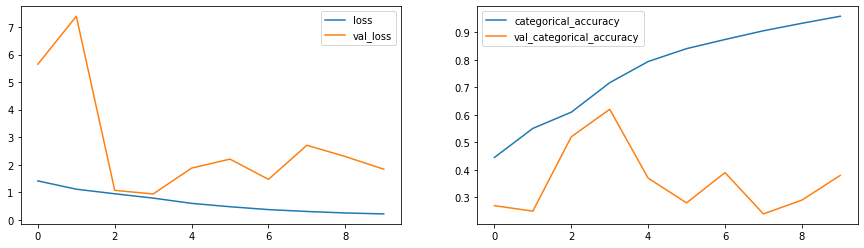

In [65]:
plot(model_5.history)

In [67]:
# Building model 6
batch_size=42
frames = 20
img_height = 140
img_width = 140
train_generator = generator(train_path, train_doc, batch_size,frames, img_height, img_width)
val_generator = generator(val_path, val_doc, batch_size, frames, img_height, img_width)
model_6 = Sequential([
                    layers.Conv3D(16, (3,3,3), input_shape=(frames,img_height,img_width,3),padding="same", activation="relu"),             
                    layers.BatchNormalization(),                
                    layers.MaxPooling3D(pool_size=(2,2,2)),
                    
                    layers.Conv3D(32, (3,3,3), padding="same", activation="relu"),
                    layers.BatchNormalization(),  
                    layers.MaxPooling3D(pool_size=(2,2,2)),
                    
                    layers.Conv3D(64, (3,3,3), padding="same", activation="relu"),
                    layers.BatchNormalization(),
                    layers.MaxPooling3D(pool_size=(2,2,2)),

                    layers.Conv3D(64, (3,3,3), padding="same", activation="relu"),
                    layers.BatchNormalization(),
                    layers.MaxPooling3D(pool_size=(2,2,2)),

                    layers.Flatten(),
                    layers.Dense(64, activation="relu"),
                    layers.BatchNormalization(),
                    layers.Dropout(0.25),
    
                    layers.Dense(64, activation="relu"),
                    layers.BatchNormalization(),
                    layers.Dropout(0.25),
                  
                    layers.Dense(num_classes, activation="softmax")
])

In [68]:
# Compiling the model
model_6.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
K.set_value(model.optimizer.learning_rate, 0.0002)

In [ ]:
# Fitting the model
model_6.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10
16/16 [==============================] - ETA: 0s - loss: 1.8315 - categorical_accuracy: 0.3318
Epoch 00001: saving model to model_init_2022-06-1509_17_52.346559/model-00001-1.83145-0.33183-1.57336-0.41000.h5
16/16 [==============================] - 68s 4s/step - loss: 1.8315 - categorical_accuracy: 0.3318 - val_loss: 1.5734 - val_categorical_accuracy: 0.4100 - lr: 1.0000e-04
Epoch 2/10
16/16 [==============================] - ETA: 0s - loss: 1.2423 - categorical_accuracy: 0.5309
Epoch 00002: saving model to model_init_2022-06-1509_17_52.346559/model-00002-1.24226-0.53092-1.90769-0.21000.h5
16/16 [==============================] - 59s 4s/step - loss: 1.2423 - categorical_accuracy: 0.5309 - val_loss: 1.9077 - val_categorical_accuracy: 0.2100 - lr: 1.0000e-04
Epoch 3/10
16/16 [==============================] - ETA: 0s - loss: 0.9046 - categorical_accuracy: 0.6456
Epoch 00003: saving model to model_init_2022-06-1509_17_52.346559/model-00003-0.90457-0.64555-2.37487-0.21000.h5
16/

In [32]:
# Building model 7
batch_size=42
frames = 16
img_height = 140
img_width = 140
train_generator = generator(train_path, train_doc, batch_size,frames, img_height, img_width)
val_generator = generator(val_path, val_doc, batch_size, frames, img_height, img_width)
model_7 = Sequential([
                    layers.Conv3D(16, (3,3,3), input_shape=(frames,img_height,img_width,3),padding="same"),
                    layers.Activation("relu"),             
                    layers.BatchNormalization(),                
                    layers.MaxPooling3D(pool_size=(2,2,2)),
                    
                    layers.Conv3D(32, (3,3,3), padding="same"),
                    layers.Activation("relu"),  
                    layers.BatchNormalization(),  
                    layers.MaxPooling3D(pool_size=(2,2,2)),
                    
                    layers.Conv3D(64, (3,3,3), padding="same"),
                    layers.Activation("relu"),  
                    layers.BatchNormalization(),
                    layers.MaxPooling3D(pool_size=(2,2,2)),

                    layers.Conv3D(64, (3,3,3), padding="same"),
                    layers.Activation("relu"),  
                    layers.BatchNormalization(),
                    layers.MaxPooling3D(pool_size=(2,2,2)),

                    layers.Flatten(),
                    layers.Dense(128, activation="relu"),
                    layers.BatchNormalization(),
                    layers.Dropout(0.25),
    
                    layers.Dense(64, activation="relu"),
                    layers.BatchNormalization(),
                    layers.Dropout(0.25),
                  
                    layers.Dense(num_classes, activation="softmax")
])

In [ ]:
# Compiling the model
model_7.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
K.set_value(model_7.optimizer.learning_rate, 0.0002)

In [36]:
# Fitting the model
model_7.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
16/16 [==============================] - ETA: 0s - loss: 1.4289 - categorical_accuracy: 0.4917source path =  datasets/Project_data/val ; batch size =  42

Epoch 00001: saving model to model_init_2022-06-1511_49_24.112865/model-00001-1.42886-0.49170-1.78217-0.25000.h5
16/16 [==============================] - 54s 4s/step - loss: 1.4289 - categorical_accuracy: 0.4917 - val_loss: 1.7822 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/20
16/16 [==============================] - ETA: 0s - loss: 0.9221 - categorical_accuracy: 0.6410
Epoch 00002: saving model to model_init_2022-06-1511_49_24.112865/model-00002-0.92210-0.64103-3.74182-0.20000.h5
16/16 [==============================] - 54s 4s/step - loss: 0.9221 - categorical_accuracy: 0.6410 - val_loss: 3.7418 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/20
16/16 [==============================] - ETA: 0s - loss: 0.5990 - categorical_accuracy: 0.7692
Epoch 00003: saving model to model_init_2022-06-1511_49_24.11286

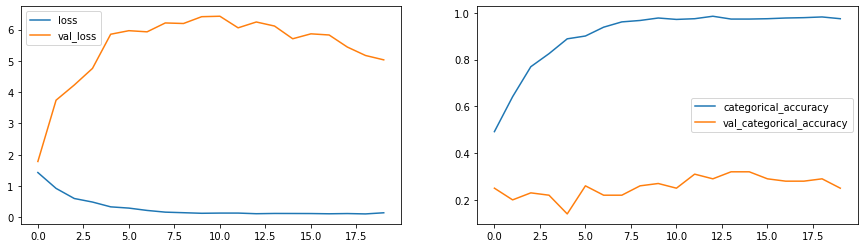

In [43]:
plot(model_7.history)

In [58]:
# Building model 8
batch_size=42
frames = 20
img_height = 140
img_width = 140
train_generator = generator(train_path, train_doc, batch_size,frames, img_height, img_width)
val_generator = generator(val_path, val_doc, batch_size, frames, img_height, img_width)
model_8 = Sequential([
                    layers.Conv3D(16, (3,3,3), input_shape=(frames,img_height,img_width,3),padding="same"),
                    layers.Activation("relu"),             
                    layers.BatchNormalization(),                
                    layers.MaxPooling3D(pool_size=(2,2,2)),
                    
                    layers.Conv3D(32, (3,3,3), padding="same"),
                    layers.Activation("relu"),  
                    layers.BatchNormalization(),  
                    layers.MaxPooling3D(pool_size=(2,2,2)),
                    
                    layers.Conv3D(32, (3,3,3), padding="same"),
                    layers.Activation("relu"),  
                    layers.BatchNormalization(),
                    layers.MaxPooling3D(pool_size=(2,2,2)),

                    layers.Flatten(),
                    layers.Dense(128, activation="relu"),
                    layers.BatchNormalization(),
                    layers.Dropout(0.5),
    
                    layers.Dense(64, activation="relu"),
                    layers.BatchNormalization(),
                    layers.Dropout(0.5),
                  
                    layers.Dense(num_classes, activation="softmax")
])

model_8.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
K.set_value(model_8.optimizer.learning_rate, 0.002)

In [47]:
# Fitting the model
model_8.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
16/16 [==============================] - ETA: 0s - loss: 2.0578 - categorical_accuracy: 0.3424source path =  datasets/Project_data/val ; batch size =  42

Epoch 00001: saving model to model_init_2022-06-1512_10_20.790582/model-00001-2.05783-0.34238-1.52770-0.33000.h5
16/16 [==============================] - 67s 4s/step - loss: 2.0578 - categorical_accuracy: 0.3424 - val_loss: 1.5277 - val_categorical_accuracy: 0.3300 - lr: 0.0010
Epoch 2/20
16/16 [==============================] - ETA: 0s - loss: 1.4230 - categorical_accuracy: 0.5053
Epoch 00002: saving model to model_init_2022-06-1512_10_20.790582/model-00002-1.42304-0.50528-3.64643-0.15000.h5
16/16 [==============================] - 69s 5s/step - loss: 1.4230 - categorical_accuracy: 0.5053 - val_loss: 3.6464 - val_categorical_accuracy: 0.1500 - lr: 0.0010
Epoch 3/20
16/16 [==============================] - ETA: 0s - loss: 1.0189 - categorical_accuracy: 0.5943
Epoch 00003: saving model to model_init_2022-06-1512_10_20.79058

In [59]:
# Building model 9
batch_size=42
frames = 16
img_height = 140
img_width = 140
train_generator = generator(train_path, train_doc, batch_size,frames, img_height, img_width)
val_generator = generator(val_path, val_doc, batch_size, frames, img_height, img_width)
model_9 = Sequential([
                    layers.Conv3D(16, (3,3,3), input_shape=(frames,img_height,img_width,3),padding="same"),
                    layers.Activation("relu"),                            
                    layers.MaxPooling3D(pool_size=(2,2,2)),
                    
                    layers.Conv3D(32, (3,3,3), padding="same"),
                    layers.Activation("relu"),   
                    layers.MaxPooling3D(pool_size=(2,2,2)),
                    
                    layers.Conv3D(32, (3,3,3), padding="same"),
                    layers.Activation("relu"),  
                    layers.MaxPooling3D(pool_size=(2,2,2)),
                    layers.Dropout(0.5),
    
                    layers.Flatten(),
                    layers.Dense(128, activation="relu"),
                    layers.BatchNormalization(),
    
                    layers.Dense(64, activation="relu"),
                    layers.BatchNormalization(),
                    layers.Dropout(0.5),
                  
                    layers.Dense(num_classes, activation="softmax")
])

model_9.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['categorical_accuracy'])
K.set_value(model_9.optimizer.learning_rate, 0.002)

In [61]:
model_9.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

source path =  datasets/Project_data/train ; batch size =  42
Epoch 1/20
16/16 [==============================] - ETA: 0s - loss: 2.5451 - categorical_accuracy: 0.1991source path =  datasets/Project_data/val ; batch size =  42

Epoch 00001: saving model to model_init_2022-06-1512_40_03.652909/model-00001-2.54512-0.19910-1.63086-0.23000.h5
16/16 [==============================] - 52s 3s/step - loss: 2.5451 - categorical_accuracy: 0.1991 - val_loss: 1.6309 - val_categorical_accuracy: 0.2300 - lr: 0.0020
Epoch 2/20
16/16 [==============================] - ETA: 0s - loss: 2.1811 - categorical_accuracy: 0.3107
Epoch 00002: saving model to model_init_2022-06-1512_40_03.652909/model-00002-2.18109-0.31071-1.78618-0.21000.h5
16/16 [==============================] - 52s 3s/step - loss: 2.1811 - categorical_accuracy: 0.3107 - val_loss: 1.7862 - val_categorical_accuracy: 0.2100 - lr: 0.0020
Epoch 3/20
16/16 [==============================] - ETA: 0s - loss: 2.1861 - categorical_accuracy: 0.3288
Ep

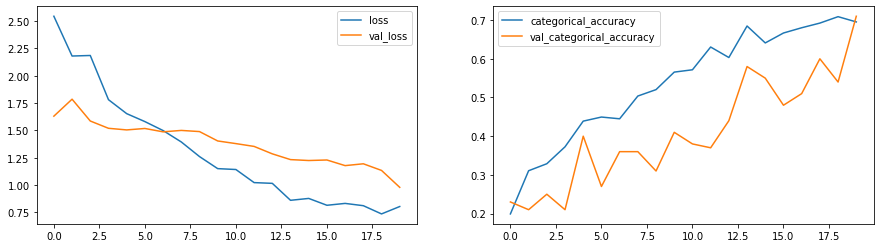

In [62]:
plot(model_9.history)

In [98]:
# Building model 10
model_10 = Sequential([
                    layers.Conv3D(32, (3,3,3), input_shape=(frames,img_height,img_width,3),padding="same", activation="relu"),
                    layers.MaxPooling3D(pool_size=(2,2,2)),
                    layers.Conv3D(32, (3,3,3), padding="same", activation="relu"),
                    layers.MaxPooling3D(pool_size=(2,2,2)),
                    layers.Conv3D(64, (3,3,3), padding="same", activation="relu"),
                    layers.MaxPooling3D(pool_size=(2,2,2)),
                    layers.Dropout(0.25),

                    layers.Flatten(),
                    layers.Dense(128, activation="relu"),
                    layers.Dense(64, activation="relu"),
                    layers.Dropout(0.25),
                    layers.Dense(num_classes, activation="softmax")
])

In [99]:
# Compiling model 10
model_10.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_10.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_45 (Conv3D)          (None, 20, 140, 140, 32)  2624      
                                                                 
 max_pooling3d_36 (MaxPoolin  (None, 10, 70, 70, 32)   0         
 g3D)                                                            
                                                                 
 conv3d_46 (Conv3D)          (None, 10, 70, 70, 32)    27680     
                                                                 
 max_pooling3d_37 (MaxPoolin  (None, 5, 35, 35, 32)    0         
 g3D)                                                            
                                                                 
 conv3d_47 (Conv3D)          (None, 5, 35, 35, 64)     55360     
                                                                 
 max_pooling3d_38 (MaxPoolin  (None, 2, 17, 17, 64)  

In [103]:
# Fitting model 10
model_10.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10
16/16 [==============================] - ETA: 0s - loss: 1.6026 - categorical_accuracy: 0.2353
Epoch 00001: saving model to model_init_2022-06-1419_56_18.589262/model-00001-1.60264-0.23529-1.57766-0.31000.h5
16/16 [==============================] - 60s 4s/step - loss: 1.6026 - categorical_accuracy: 0.2353 - val_loss: 1.5777 - val_categorical_accuracy: 0.3100 - lr: 0.0100
Epoch 2/10
16/16 [==============================] - ETA: 0s - loss: 1.5974 - categorical_accuracy: 0.2217
Epoch 00002: saving model to model_init_2022-06-1419_56_18.589262/model-00002-1.59736-0.22172-1.57834-0.24000.h5
16/16 [==============================] - 61s 4s/step - loss: 1.5974 - categorical_accuracy: 0.2217 - val_loss: 1.5783 - val_categorical_accuracy: 0.2400 - lr: 0.0100
Epoch 3/10
16/16 [==============================] - ETA: 0s - loss: 1.5814 - categorical_accuracy: 0.2911
Epoch 00003: saving model to model_init_2022-06-1419_56_18.589262/model-00003-1.58137-0.29110-1.53436-0.29000.h5
16/16 [====

In [105]:
# Building model 11
model_11 = Sequential([
                    layers.Conv3D(32, (3,3,3), input_shape=(frames,img_height,img_width,3),padding="same", activation="relu"),
                    layers.MaxPooling3D(pool_size=(2,2,2)),
                    layers.Conv3D(32, (3,3,3), padding="same", activation="relu"),
                    layers.MaxPooling3D(pool_size=(2,2,2)),
                    layers.Conv3D(64, (3,3,3), padding="same", activation="relu"),
                    layers.MaxPooling3D(pool_size=(2,2,2)),
                    layers.Dropout(0.25),

                    layers.Flatten(),
                    layers.Dense(128, activation="relu"),
                    layers.Dense(64, activation="relu"),
                    layers.Dense(num_classes, activation="softmax")
])
# Compiling model 11
model_11.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_11.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_48 (Conv3D)          (None, 20, 140, 140, 32)  2624      
                                                                 
 max_pooling3d_39 (MaxPoolin  (None, 10, 70, 70, 32)   0         
 g3D)                                                            
                                                                 
 conv3d_49 (Conv3D)          (None, 10, 70, 70, 32)    27680     
                                                                 
 max_pooling3d_40 (MaxPoolin  (None, 5, 35, 35, 32)    0         
 g3D)                                                            
                                                                 
 conv3d_50 (Conv3D)          (None, 5, 35, 35, 64)     55360     
                                                                 
 max_pooling3d_41 (MaxPoolin  (None, 2, 17, 17, 64)  

In [107]:
# Fitting model 11
model_11.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10
16/16 [==============================] - ETA: 0s - loss: 1.7300 - categorical_accuracy: 0.1991
Epoch 00001: saving model to model_init_2022-06-1420_09_40.067462/model-00001-1.72998-0.19910-1.59087-0.23000.h5
16/16 [==============================] - 62s 4s/step - loss: 1.7300 - categorical_accuracy: 0.1991 - val_loss: 1.5909 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/10
16/16 [==============================] - ETA: 0s - loss: 1.5801 - categorical_accuracy: 0.2459
Epoch 00002: saving model to model_init_2022-06-1420_09_40.067462/model-00002-1.58010-0.24585-1.53613-0.25000.h5
16/16 [==============================] - 60s 4s/step - loss: 1.5801 - categorical_accuracy: 0.2459 - val_loss: 1.5361 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/10
16/16 [==============================] - ETA: 0s - loss: 1.4460 - categorical_accuracy: 0.3756
Epoch 00003: saving model to model_init_2022-06-1420_09_40.067462/model-00003-1.44600-0.37557-1.44535-0.39000.h5
16/16 [====

In [108]:
# Building model 12
model_12 = Sequential([
                    layers.Conv3D(32, (3,3,3), input_shape=(frames,img_height,img_width,3),padding="same", activation="relu"),
                    layers.MaxPooling3D(pool_size=(2,2,2)),
                    layers.Conv3D(32, (3,3,3), padding="same", activation="relu"),
                    layers.MaxPooling3D(pool_size=(2,2,2)),
                    layers.Conv3D(64, (3,3,3), padding="same", activation="relu"),
                    layers.MaxPooling3D(pool_size=(2,2,2)),
                    layers.Dropout(0.5),

                    layers.Flatten(),
                    layers.Dense(128, activation="relu"),
                    layers.Dense(64, activation="relu"),
                    layers.Dense(num_classes, activation="softmax")
])
# Compiling model 12
model_12.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_12.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_51 (Conv3D)          (None, 20, 140, 140, 32)  2624      
                                                                 
 max_pooling3d_42 (MaxPoolin  (None, 10, 70, 70, 32)   0         
 g3D)                                                            
                                                                 
 conv3d_52 (Conv3D)          (None, 10, 70, 70, 32)    27680     
                                                                 
 max_pooling3d_43 (MaxPoolin  (None, 5, 35, 35, 32)    0         
 g3D)                                                            
                                                                 
 conv3d_53 (Conv3D)          (None, 5, 35, 35, 64)     55360     
                                                                 
 max_pooling3d_44 (MaxPoolin  (None, 2, 17, 17, 64)  

In [110]:
# Fitting model 12
model_12.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10
16/16 [==============================] - ETA: 0s - loss: 1.7002 - categorical_accuracy: 0.2112
Epoch 00001: saving model to model_init_2022-06-1420_22_02.797894/model-00001-1.70018-0.21116-1.56616-0.24000.h5
16/16 [==============================] - 66s 4s/step - loss: 1.7002 - categorical_accuracy: 0.2112 - val_loss: 1.5662 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/10
16/16 [==============================] - ETA: 0s - loss: 1.5570 - categorical_accuracy: 0.2640
Epoch 00002: saving model to model_init_2022-06-1420_22_02.797894/model-00002-1.55704-0.26395-1.49621-0.51000.h5
16/16 [==============================] - 60s 4s/step - loss: 1.5570 - categorical_accuracy: 0.2640 - val_loss: 1.4962 - val_categorical_accuracy: 0.5100 - lr: 0.0010
Epoch 3/10
16/16 [==============================] - ETA: 0s - loss: 1.3291 - categorical_accuracy: 0.4314
Epoch 00003: saving model to model_init_2022-06-1420_22_02.797894/model-00003-1.32905-0.43137-1.20362-0.51000.h5
16/16 [====

### **CNN + RNN Stacked Architecture**:

In [12]:
# Building model 13 using GRU
frames = 20
img_height = 140
img_width = 140
batch_size=20
input_shape=(frames,img_height,img_width,3)
model_13 = Sequential([
                    (layers.TimeDistributed(Conv2D(32, (3,3),padding="same", activation="relu"),  
                                                  input_shape=input_shape)),
                    layers.TimeDistributed(BatchNormalization()),
                    layers.TimeDistributed(MaxPooling2D(pool_size=(2,2))),
    
                    layers.TimeDistributed(Conv2D(32, (3,3),padding="same", activation="relu")),
                    layers.TimeDistributed(BatchNormalization()),
                    layers.TimeDistributed(MaxPooling2D(pool_size=(2,2))),
    
                    layers.TimeDistributed(Conv2D(32, (3,3),padding="same", activation="relu")),
                    layers.TimeDistributed(BatchNormalization()),
                    layers.TimeDistributed(MaxPooling2D(pool_size=(2,2))),
    
                    layers.TimeDistributed(Conv2D(32, (3,3),padding="same", activation="relu")),
                    layers.TimeDistributed(BatchNormalization()),
                    layers.TimeDistributed(MaxPooling2D(pool_size=(2,2))),

                    layers.TimeDistributed(Flatten()),
    
                    layers.GRU(64),
                    layers.Dropout(0.25),
    
                    layers.Dense(64, activation="relu"),
                    layers.Dropout(0.25),
    
                    layers.Dense(num_classes, activation="softmax")
])

In [13]:
# Compiling the model
optimiser = tf.keras.optimizers.Adam(lr=0.0002)
model_13.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [14]:
# Checking the summary
model_13.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 140, 140, 32)  896      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 140, 140, 32)  128      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 70, 70, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 70, 70, 32)   9248      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 70, 70, 32)  

In [16]:
# Fitting model 13
model_13.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
16/16 [==============================] - ETA: 0s - loss: 1.6282 - categorical_accuracy: 0.2821source path =  datasets/Project_data/val ; batch size =  42

Epoch 00001: saving model to model_init_2022-06-1513_50_47.994374/model-00001-1.62819-0.28205-1.62516-0.21000.h5
16/16 [==============================] - 68s 4s/step - loss: 1.6282 - categorical_accuracy: 0.2821 - val_loss: 1.6252 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/20
16/16 [==============================] - ETA: 0s - loss: 1.3243 - categorical_accuracy: 0.4495
Epoch 00002: saving model to model_init_2022-06-1513_50_47.994374/model-00002-1.32430-0.44947-1.71421-0.15000.h5
16/16 [==============================] - 68s 4s/step - loss: 1.3243 - categorical_accuracy: 0.4495 - val_loss: 1.7142 - val_categorical_accuracy: 0.1500 - lr: 2.0000e-04
Epoch 3/20
16/16 [==============================] - ETA: 0s - loss: 1.1896 - categorical_accuracy: 0.5173
Epoch 00003: saving model to model_init_2022-06-1513_50_

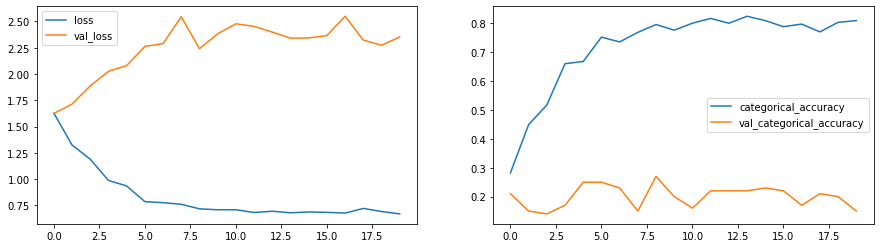

In [17]:
# Plotting the loss and accuracy
plot(model_13.history)

In [20]:
# Building model 13 using lstm
frames = 20
img_height = 140
img_width = 140
batch_size=20
input_shape=(frames,img_height,img_width,3)
model_14 = Sequential([
                    (layers.TimeDistributed(Conv2D(32, (3,3),padding="same", activation="relu"),  
                                                  input_shape=input_shape)),
                    layers.TimeDistributed(BatchNormalization()),
                    layers.TimeDistributed(MaxPooling2D(pool_size=(2,2))),
    
                    layers.TimeDistributed(Conv2D(32, (3,3),padding="same", activation="relu")),
                    layers.TimeDistributed(BatchNormalization()),
                    layers.TimeDistributed(MaxPooling2D(pool_size=(2,2))),
    
                    layers.TimeDistributed(Conv2D(32, (3,3),padding="same", activation="relu")),
                    layers.TimeDistributed(BatchNormalization()),
                    layers.TimeDistributed(MaxPooling2D(pool_size=(2,2))),
    
                    layers.TimeDistributed(Conv2D(32, (3,3),padding="same", activation="relu")),
                    layers.TimeDistributed(BatchNormalization()),
                    layers.TimeDistributed(MaxPooling2D(pool_size=(2,2))),

                    layers.TimeDistributed(Flatten()),
                    layers.LSTM(128, activation="relu"),
                    layers.BatchNormalization(),
                    layers.Dropout(0.25),
    
                    layers.Dense(64, activation="relu"),
                    layers.BatchNormalization(),
                    layers.Dropout(0.25),
    
                    layers.Dense(num_classes, activation="softmax")
])

In [21]:
# Compiling the model
optimiser = tf.keras.optimizers.Adam(lr=0.0002)
model_14.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [22]:
model_14.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_26 (TimeDi  (None, 20, 140, 140, 32)  896      
 stributed)                                                      
                                                                 
 time_distributed_27 (TimeDi  (None, 20, 140, 140, 32)  128      
 stributed)                                                      
                                                                 
 time_distributed_28 (TimeDi  (None, 20, 70, 70, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_29 (TimeDi  (None, 20, 70, 70, 32)   9248      
 stributed)                                                      
                                                                 
 time_distributed_30 (TimeDi  (None, 20, 70, 70, 32)  

In [23]:
# Fitting model 14
model_14.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20


2022-06-15 14:56:35.180937: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


16/16 [==============================] - ETA: 0s - loss: 2.2413 - categorical_accuracy: 0.2217source path =  datasets/Project_data/val ; batch size =  42

Epoch 00001: saving model to model_init_2022-06-1514_54_47.034215/model-00001-2.24135-0.22172-1.60840-0.18000.h5
16/16 [==============================] - 70s 4s/step - loss: 2.2413 - categorical_accuracy: 0.2217 - val_loss: 1.6084 - val_categorical_accuracy: 0.1800 - lr: 2.0000e-04
Epoch 2/20
16/16 [==============================] - ETA: 0s - loss: 1.8099 - categorical_accuracy: 0.3213
Epoch 00002: saving model to model_init_2022-06-1514_54_47.034215/model-00002-1.80989-0.32127-1.61868-0.22000.h5
16/16 [==============================] - 68s 4s/step - loss: 1.8099 - categorical_accuracy: 0.3213 - val_loss: 1.6187 - val_categorical_accuracy: 0.2200 - lr: 2.0000e-04
Epoch 3/20
16/16 [==============================] - ETA: 0s - loss: 1.5716 - categorical_accuracy: 0.3997
Epoch 00003: saving model to model_init_2022-06-1514_54_47.034215/m

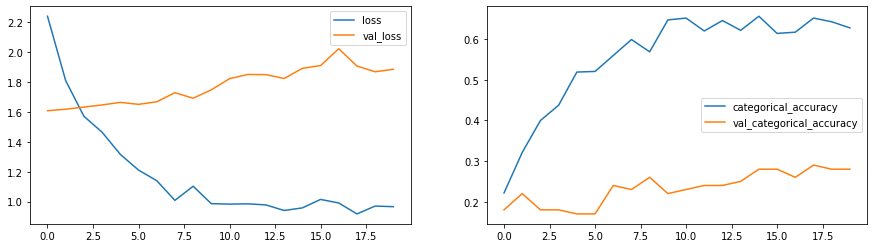

In [24]:
plot(model_14.history)